<h2 align=left>Checking GPU and importing dependencies</h2>



---

In [1]:
!nvidia-smi

Mon Apr 18 04:28:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

#logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
#shutil.rmtree(logdir, ignore_errors=True)

Version:  2.8.0
Hub version:  0.12.0
GPU is available


## Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [4]:
df = pd.read_csv(
    "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
    compression='zip',
    low_memory=False
)

In [5]:
df.shape

(1306122, 3)

In [6]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


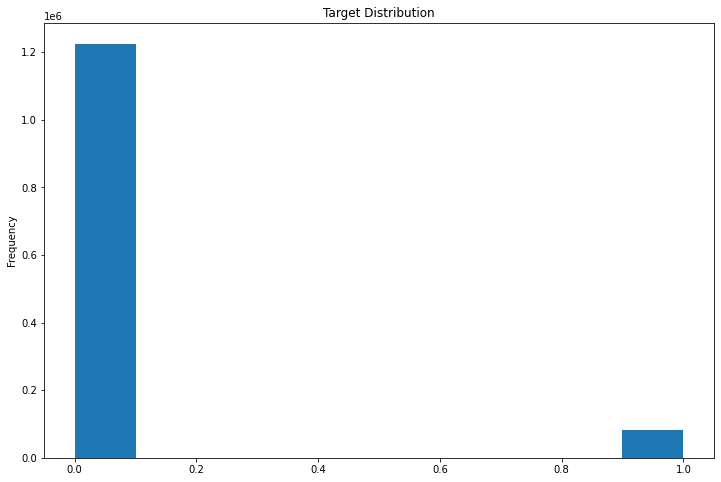

In [7]:
df.target.plot(kind='hist', title="Target Distribution")

In [37]:
from sklearn.model_selection import train_test_split

train_df, remaning = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values) # Using 1% of data for train dataframe

In [9]:
train_df.head()

,qid,question_text,target
147144,1cc67025519a7e0d23a5,What is your experience living in Venezuela in...,0
978379,bfabc9f014b5d3e1b08c,In which state/city the price of property is h...,0
588051,73315f395204472d6afc,"Do rich blacks also call poor whites, “White T...",0
1231527,f1563710d0cd93650e26,Should my 5 yr old son and 2 yr old daughter s...,0
1284232,fbada72d37e57f01d18f,Why do we have parents?,0


In [10]:
remaning.head()

,qid,question_text,target
111140,15c03a1f95aa4382c27f,Is capital punishment justified in some cases?,0
1202339,eba4e7cf26e6ac21d507,What safety precautions should be taken when b...,0
690334,8736705c8a8b4c435602,When does health insurance start for full time...,0
1018174,c786a0656e82f85f43ff,I've never undergone any formal vocal training...,0
1046615,cd16aff5adfcb42986ca,Can a CA student dream of a startup?,0


In [11]:
validation_df, _ = train_test_split(remaning, random_state=42, train_size=0.001, stratify=remaning.target.values) # usinng 0.001% data in validation datafram,e

print(f'train size: {train_df.shape}\nvalidation size: {validation_df.shape}')

train size: (13061, 3)
validation size: (1293, 3)


In [12]:
validation_df.head()

,qid,question_text,target
844064,a569a92ffd40a6045e71,Should go for CCIE (security) as a fresher?,0
1192230,e9a79964d201bb0a4ede,What has inspired K'naan to write his poems?,0
660379,815c6a71a616b8936af5,Why does my boyfriend not enjoy pleasing me se...,0
1282554,fb5bfc39e86b68f02289,What does being a coward mean to you?,0
1112464,d9fd165ac01e77238443,Has anyone on Quora encountered a deceased dog...,0


In [13]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [14]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## Task 4: TensorFlow Hub for Natural Language Processing

In [15]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Tasks 5 & 6: Define Function to Build and Compile Models

In [16]:
import time
import os
def get_log_path(log_dir="logs/fit"):
  uniqueName = time.strftime("log_%Y_%m_%d_%H_%M_%S")
  log_path = os.path.join(log_dir, uniqueName)
  print(f"savings logs at: {log_path}")

  return log_path

log_dir = get_log_path()

savings logs at: logs/fit/log_2022_04_18_04_30_23


In [17]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

EpochDots_cb = tfdocs.modeling.EpochDots()

CALLBACKS_LIST = [tensorboard_cb, early_stopping_cb, EpochDots_cb]

In [18]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([
        hub_layer,
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.summary()

    history = model.fit(
        train_df.question_text,
        train_df.target,
        epochs = 100,
        validation_data = (validation_df.question_text, validation_df.target),# validation data is tuple of feature and target
        callbacks = CALLBACKS_LIST,
        verbose=0
    )
    
    return history

## Task 7: Train Various Text Classification Models

In [19]:
histories = {} # will saave history object returned by train_and_evaluate_model. So I can compare different model matrices to figure out which is best

### MODEL 1

In [20]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [21]:
histories['gnews-swivel-20dim'] = train_and_evaluate_model(
                                                                        module_url, embed_size=20, 
                                                                        name='gnews-swivel-20dim',
                                                                        trainable=False
                                                                     )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 21,889
Non-trainable params: 400,020
_________________________________________________________________

Epoch: 0, accuracy:0.9381,  loss:0.2477,  val_accuracy:0.9381,  val_loss:0.1927,  
..........

### MODEL 2

In [22]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [23]:
histories['nnlm-en-dim50'] = train_and_evaluate_model(
                                                                        module_url, embed_size=50, 
                                                                        name='nnlm-en-dim50',
                                                                        trainable=False
                                                                     )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 256)               13056     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 29,569
Non-trainable params: 48,190,600
_________________________________________________________________

Epoch: 0, accuracy:0.9380,  loss:0.3099,  val_accuracy:0.9381,  val_loss:0.2184,  
...................

### MODEL 3


In [24]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [25]:
histories['nnnlm-en-dim128'] = train_and_evaluate_model(
                                                                        module_url, embed_size=128, 
                                                                        name='nnnlm-en-dim128',
                                                                        trainable=False
                                                                     )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________

Epoch: 0, accuracy:0.9187,  loss:0.3305,  val_accuracy:0.9381,  val_loss:0.2096,  
..............

**NOTE**- Only training last three dense layers

## Task 8: Compare Accuracy and Loss Curves

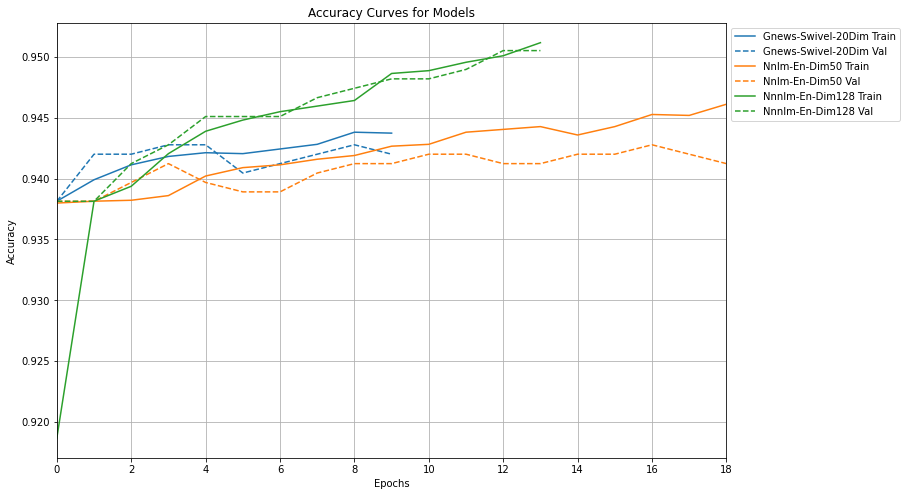

In [26]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

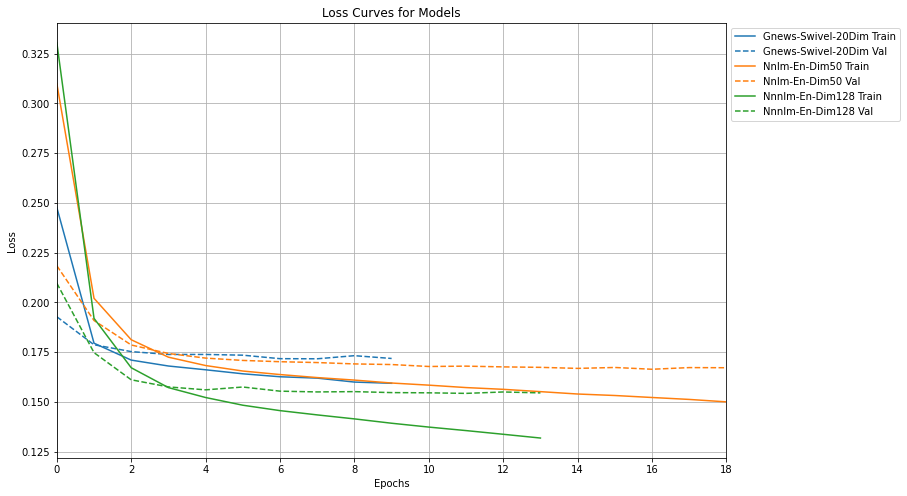

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 9: Fine-tune Model from TF Hub

This time will be training *hub_layer* of **gnews-swivel-20dim** mode  by setting  `trainable=True`

### MODEL 4

In [28]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [29]:
histories['gnews-swivel-20dim-train-hub-layer'] = train_and_evaluate_model(
                                                                        module_url, embed_size=20, 
                                                                        name='gnews-swivel-20dim',
                                                                        trainable=True
                                                                     )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_9 (Dense)             (None, 256)               5376      
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.9077,  loss:0.2925,  val_accuracy:0.9381,  val_loss:0.2024,  
............

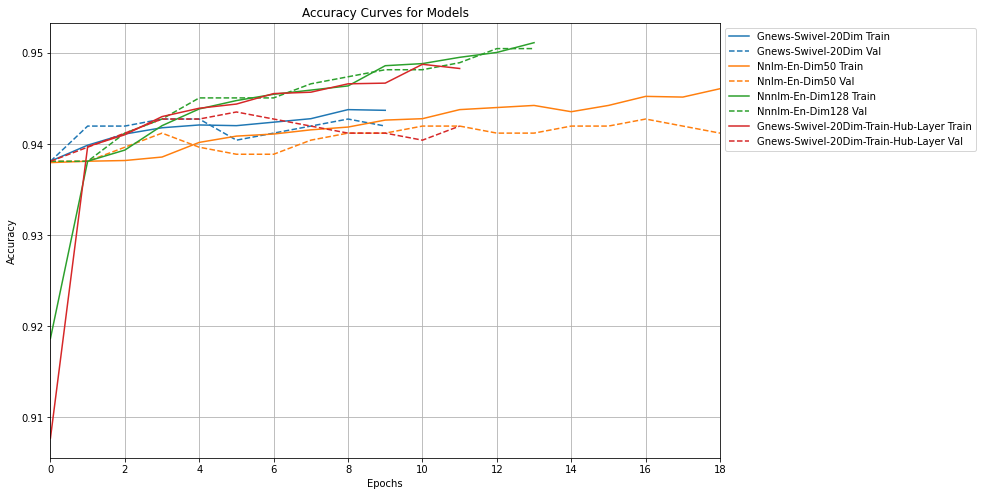

In [30]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

## Task 10: Train Bigger Models and Visualize Metrics with TensorBoard

### MODEL 5

In [31]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [32]:
histories['universal-sentence-encoder'] = train_and_evaluate_model(
                                                                  module_url, embed_size=512, 
                                                                  name='universal-sentence-encoder',
                                                                  trainable=False
                                                                     )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________

Epoch: 0, accuracy:0.9279,  loss:0.3143,  val_accuracy:0.9381,  val_loss:0.1790,  
..........

### MODEL 6

In [33]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [34]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(
                                                                        module_url, embed_size=512, 
                                                                        name='universal-sentence-encoder-large',
                                                                        trainable=False
                                                                     )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.9357,  loss:0.3038,  val_accuracy:0.9381,  val_loss:0.1700,  
..............

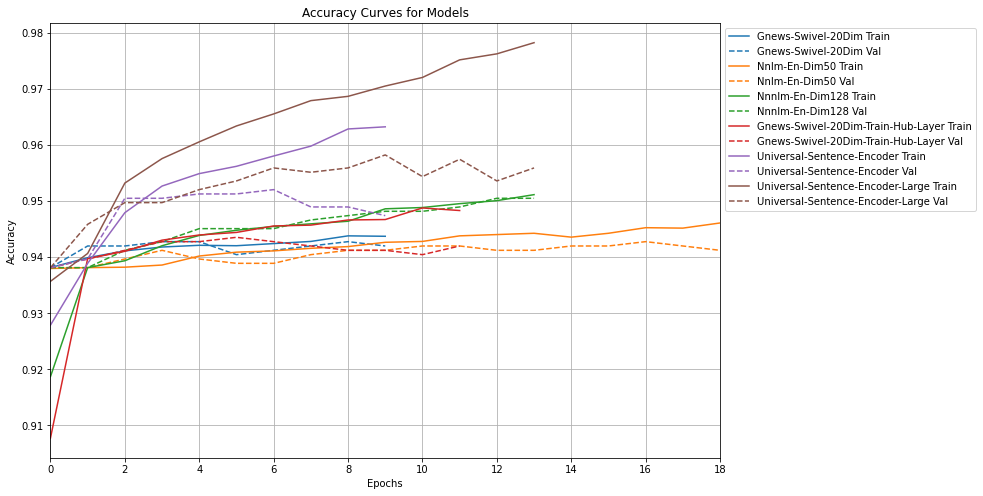

In [35]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

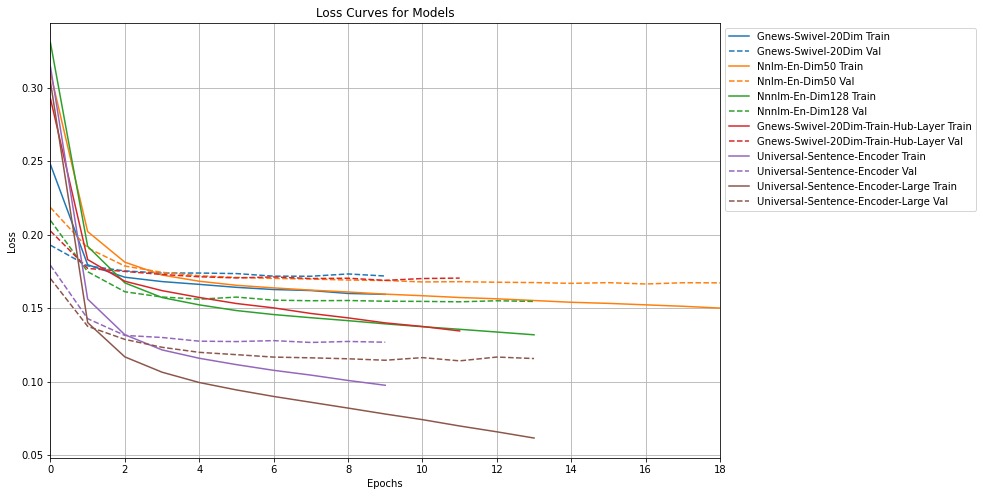

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()